In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
#jax.config.update('jax_default_device', jax.devices('cpu')[0])

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm
from models import *

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


2025-02-14 17:12:52.744440: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 50/50 [00:00<00:00, 265.09it/s]


In [2]:
from jaxinterp2d import interp2d, CartesianGrid

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0
speed_of_light = constants.c.to('km/s').value

zMax = 5.0
zgrid = jnp.expm1(np.linspace(np.log(1), np.log(zMax+1), 1000))
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,50)

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 50/50 [00:00<00:00, 780.52it/s]


In [3]:
import pickle
from dynesty.utils import resample_equal
from dynesty import NestedSampler, DynamicNestedSampler
import multiprocessing as multi
import corner 

dlogz_plbump = []
dlogz_plbump_err = []
post_samples_plbump = []

file = open('PLB','rb')
dres = pickle.load(file)

dlogZdynesty = dres.logz[-1]        # value of logZ
dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

dlogz_plbump.append(dlogZdynesty)
dlogz_plbump_err.append(dlogZerrdynesty)

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)
post_samples_plbump.append(dpostsamples)
print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))


Marginalised evidence (using dynamic sampler) is -1519.508137992134 ± 0.05788562960409826
Number of posterior samples (using dynamic sampler) is 69148


In [4]:
dlogz_plplbump = []
dlogz_plplbump_err = []
post_samples_plplbump = []

file = open('PLPLB','rb')
dres = pickle.load(file)

dlogZdynesty = dres.logz[-1]        # value of logZ
dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

dlogz_plplbump.append(dlogZdynesty)
dlogz_plplbump_err.append(dlogZerrdynesty)

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)
post_samples_plplbump.append(dpostsamples)
print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))


Marginalised evidence (using dynamic sampler) is -1518.8368810963589 ± 0.06394353443738376
Number of posterior samples (using dynamic sampler) is 69693


In [5]:
dlogz_plpl = []
dlogz_plpl_err = []
post_samples_plpl = []

file = open('PLPL','rb')
dres = pickle.load(file)

dlogZdynesty = dres.logz[-1]        # value of logZ
dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

dlogz_plpl.append(dlogZdynesty)
dlogz_plpl_err.append(dlogZerrdynesty)

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)
post_samples_plpl.append(dpostsamples)
print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))


Marginalised evidence (using dynamic sampler) is -1518.9471207215815 ± 0.05905599152618848
Number of posterior samples (using dynamic sampler) is 67810


In [6]:
dlogz_plbump_gwtc3 = dlogz_plbump[0]/np.log(10) #-1541.0868426782517 ± 0.11473619570366217
dlogz_plplbump_gwtc3 = dlogz_plplbump[0]/np.log(10) #-1540.9587754964505 ± 0.12321255167507217
dlogz_plpl_gwtc3 = dlogz_plpl[0]/np.log(10) #-1540.5063649973756 ± 0.11017407985356721


logBF_plplbump_gwtc3 = dlogz_plplbump_gwtc3 - dlogz_plbump_gwtc3
logBF_plpl_gwtc3 = dlogz_plpl_gwtc3 - dlogz_plbump_gwtc3
print(logBF_plplbump_gwtc3)
print(logBF_plpl_gwtc3)
print(logBF_plplbump_gwtc3 - logBF_plpl_gwtc3)

0.29152316577460624
0.24364670485340412
0.047876460921202124


In [7]:
dlogz_plbump_gwtc3 = dlogz_plbump[0]/np.log(10) #-1541.0868426782517 ± 0.11473619570366217
dlogz_plplbump_gwtc3 = dlogz_plplbump[0]/np.log(10) #-1540.9587754964505 ± 0.12321255167507217
dlogz_plpl_gwtc3 = dlogz_plpl[0]/np.log(10) #-1540.5063649973756 ± 0.11017407985356721


logBF_plplbump_gwtc3 = dlogz_plplbump_gwtc3 - dlogz_plbump_gwtc3
logBF_plpl_gwtc3 = dlogz_plpl_gwtc3 - dlogz_plbump_gwtc3
print(logBF_plplbump_gwtc3)
print(logBF_plpl_gwtc3)
print(logBF_plplbump_gwtc3 - logBF_plpl_gwtc3)

0.29152316577460624
0.24364670485340412
0.047876460921202124


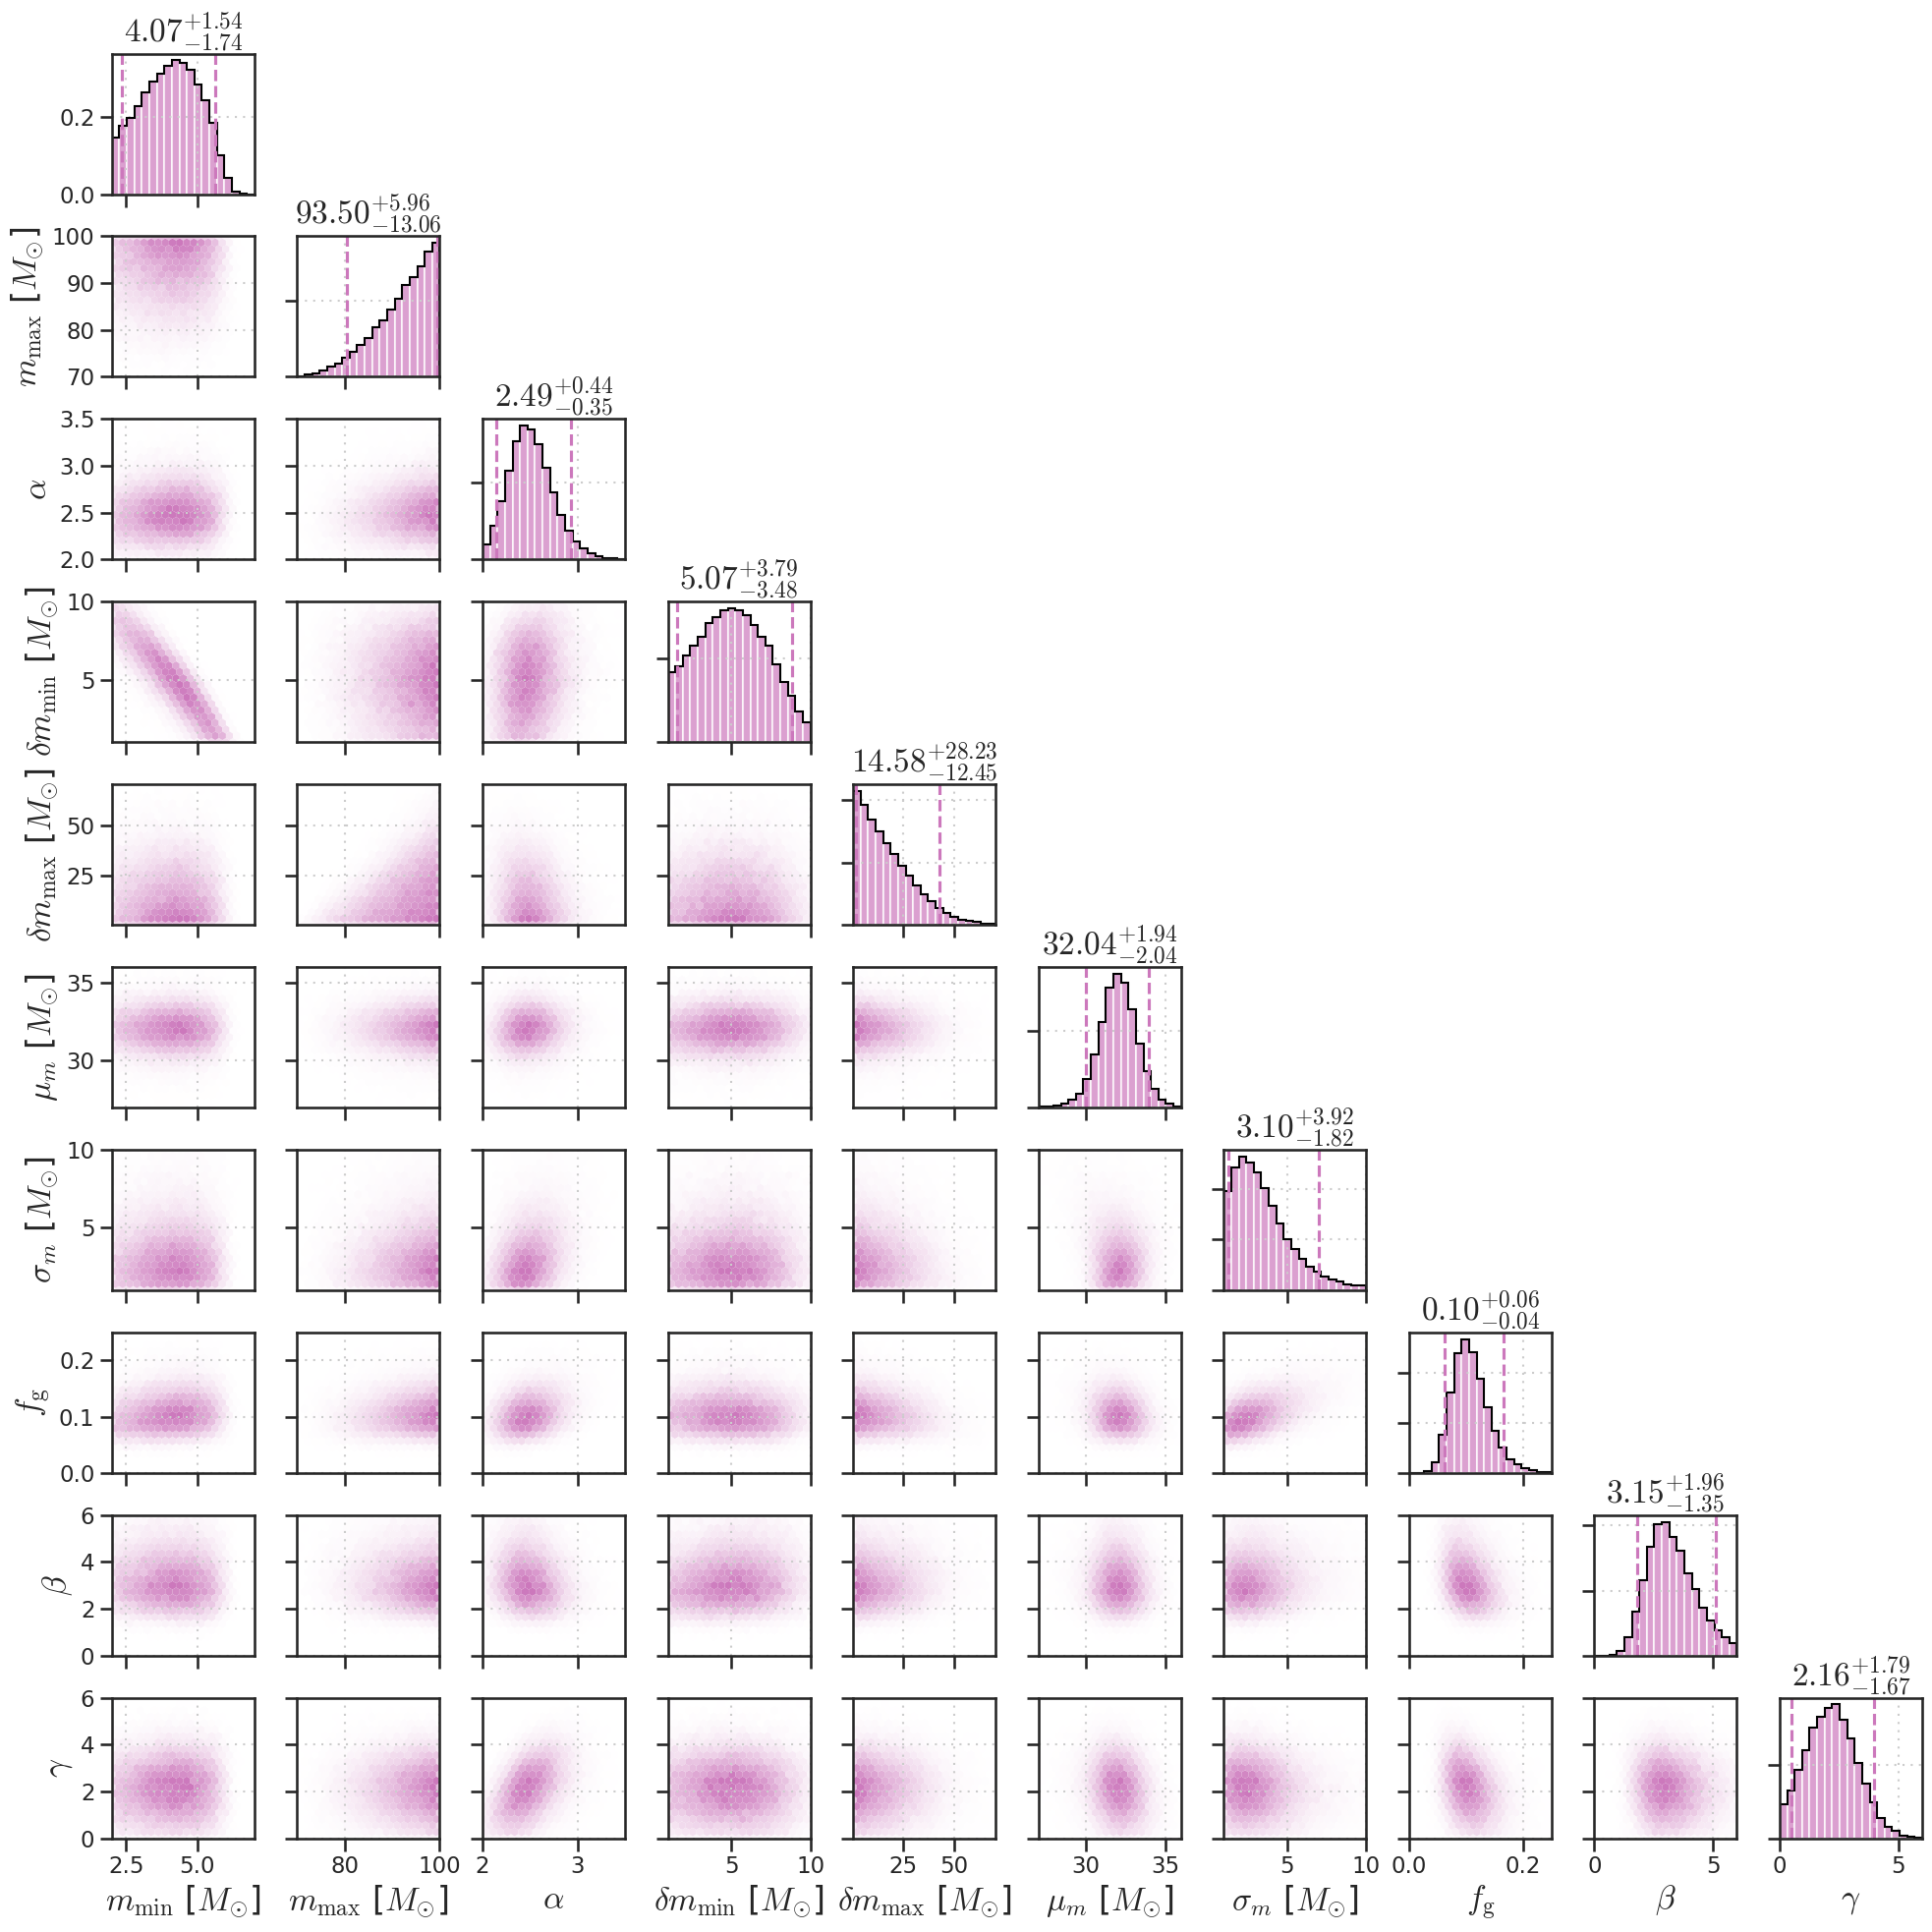

In [8]:
from makeCorner2 import plot_corner

dpostsamples = post_samples_plbump[0]
gamma_1 = dpostsamples[:,0]
mmin_1 = dpostsamples[:,1]
mmax_1 = dpostsamples[:,2]
alpha_1 = dpostsamples[:,3]
dm_mmin_1 = dpostsamples[:,4]
dm_mmax_1 = dpostsamples[:,5]
beta = dpostsamples[:,6]
mu = dpostsamples[:,7]
sigma = dpostsamples[:,8]
f1 = dpostsamples[:,9]

plbump_labels = [r"$m_{\rm{min}}$ [$M_{\odot}$]",
                 r"$m_{\rm{max}}$ [$M_{\odot}$]",
                 r"$\alpha$",
                 r"$\delta m_{\rm{min}}$ [$M_{\odot}$]",
                 r"$\delta m_{\rm{max}}$ [$M_{\odot}$]",
                 r"$\mu_{m}$ [$M_{\odot}$]",
                 r"$\sigma_{m}$ [$M_{\odot}$]",
                 r'$f_{\rm{g}}$',
                 r"$\beta$",
                 r"$\gamma$"]

plot_data = {
    'm_min_1':{'data':mmin_1,'plot_bounds':(2,7),'label':plbump_labels[0]},
    'm_max_1':{'data':mmax_1,'plot_bounds':(70,100),'label':plbump_labels[1]},
    'alpha_1':{'data':alpha_1,'plot_bounds':(2,3.5),'label':plbump_labels[2]},
    'dm_mmin_1':{'data':dm_mmin_1,'plot_bounds':(1,10),'label':plbump_labels[3]},
    'dm_mmax_1':{'data':dm_mmax_1,'plot_bounds':(1,70),'label':plbump_labels[4]},
    'mu':{'data':mu,'plot_bounds':(27,36),'label':plbump_labels[5]},
    'sigma':{'data':sigma,'plot_bounds':(1,10),'label':plbump_labels[6]},
    'f':{'data':f1,'plot_bounds':(0,0.25),'label':plbump_labels[7]},    
    'beta':{'data':beta,'plot_bounds':(0,6),'label':plbump_labels[8]},
    'gamma':{'data':gamma_1,'plot_bounds':(0,6),'label':plbump_labels[9]}

}

fig = plt.figure(figsize=(20,20))
plot_corner(fig,plot_data,c[4],labelsize=24,title_size=24)

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.savefig('PLB_corner.pdf',bbox_inches='tight',dpi=200)
plt.show()

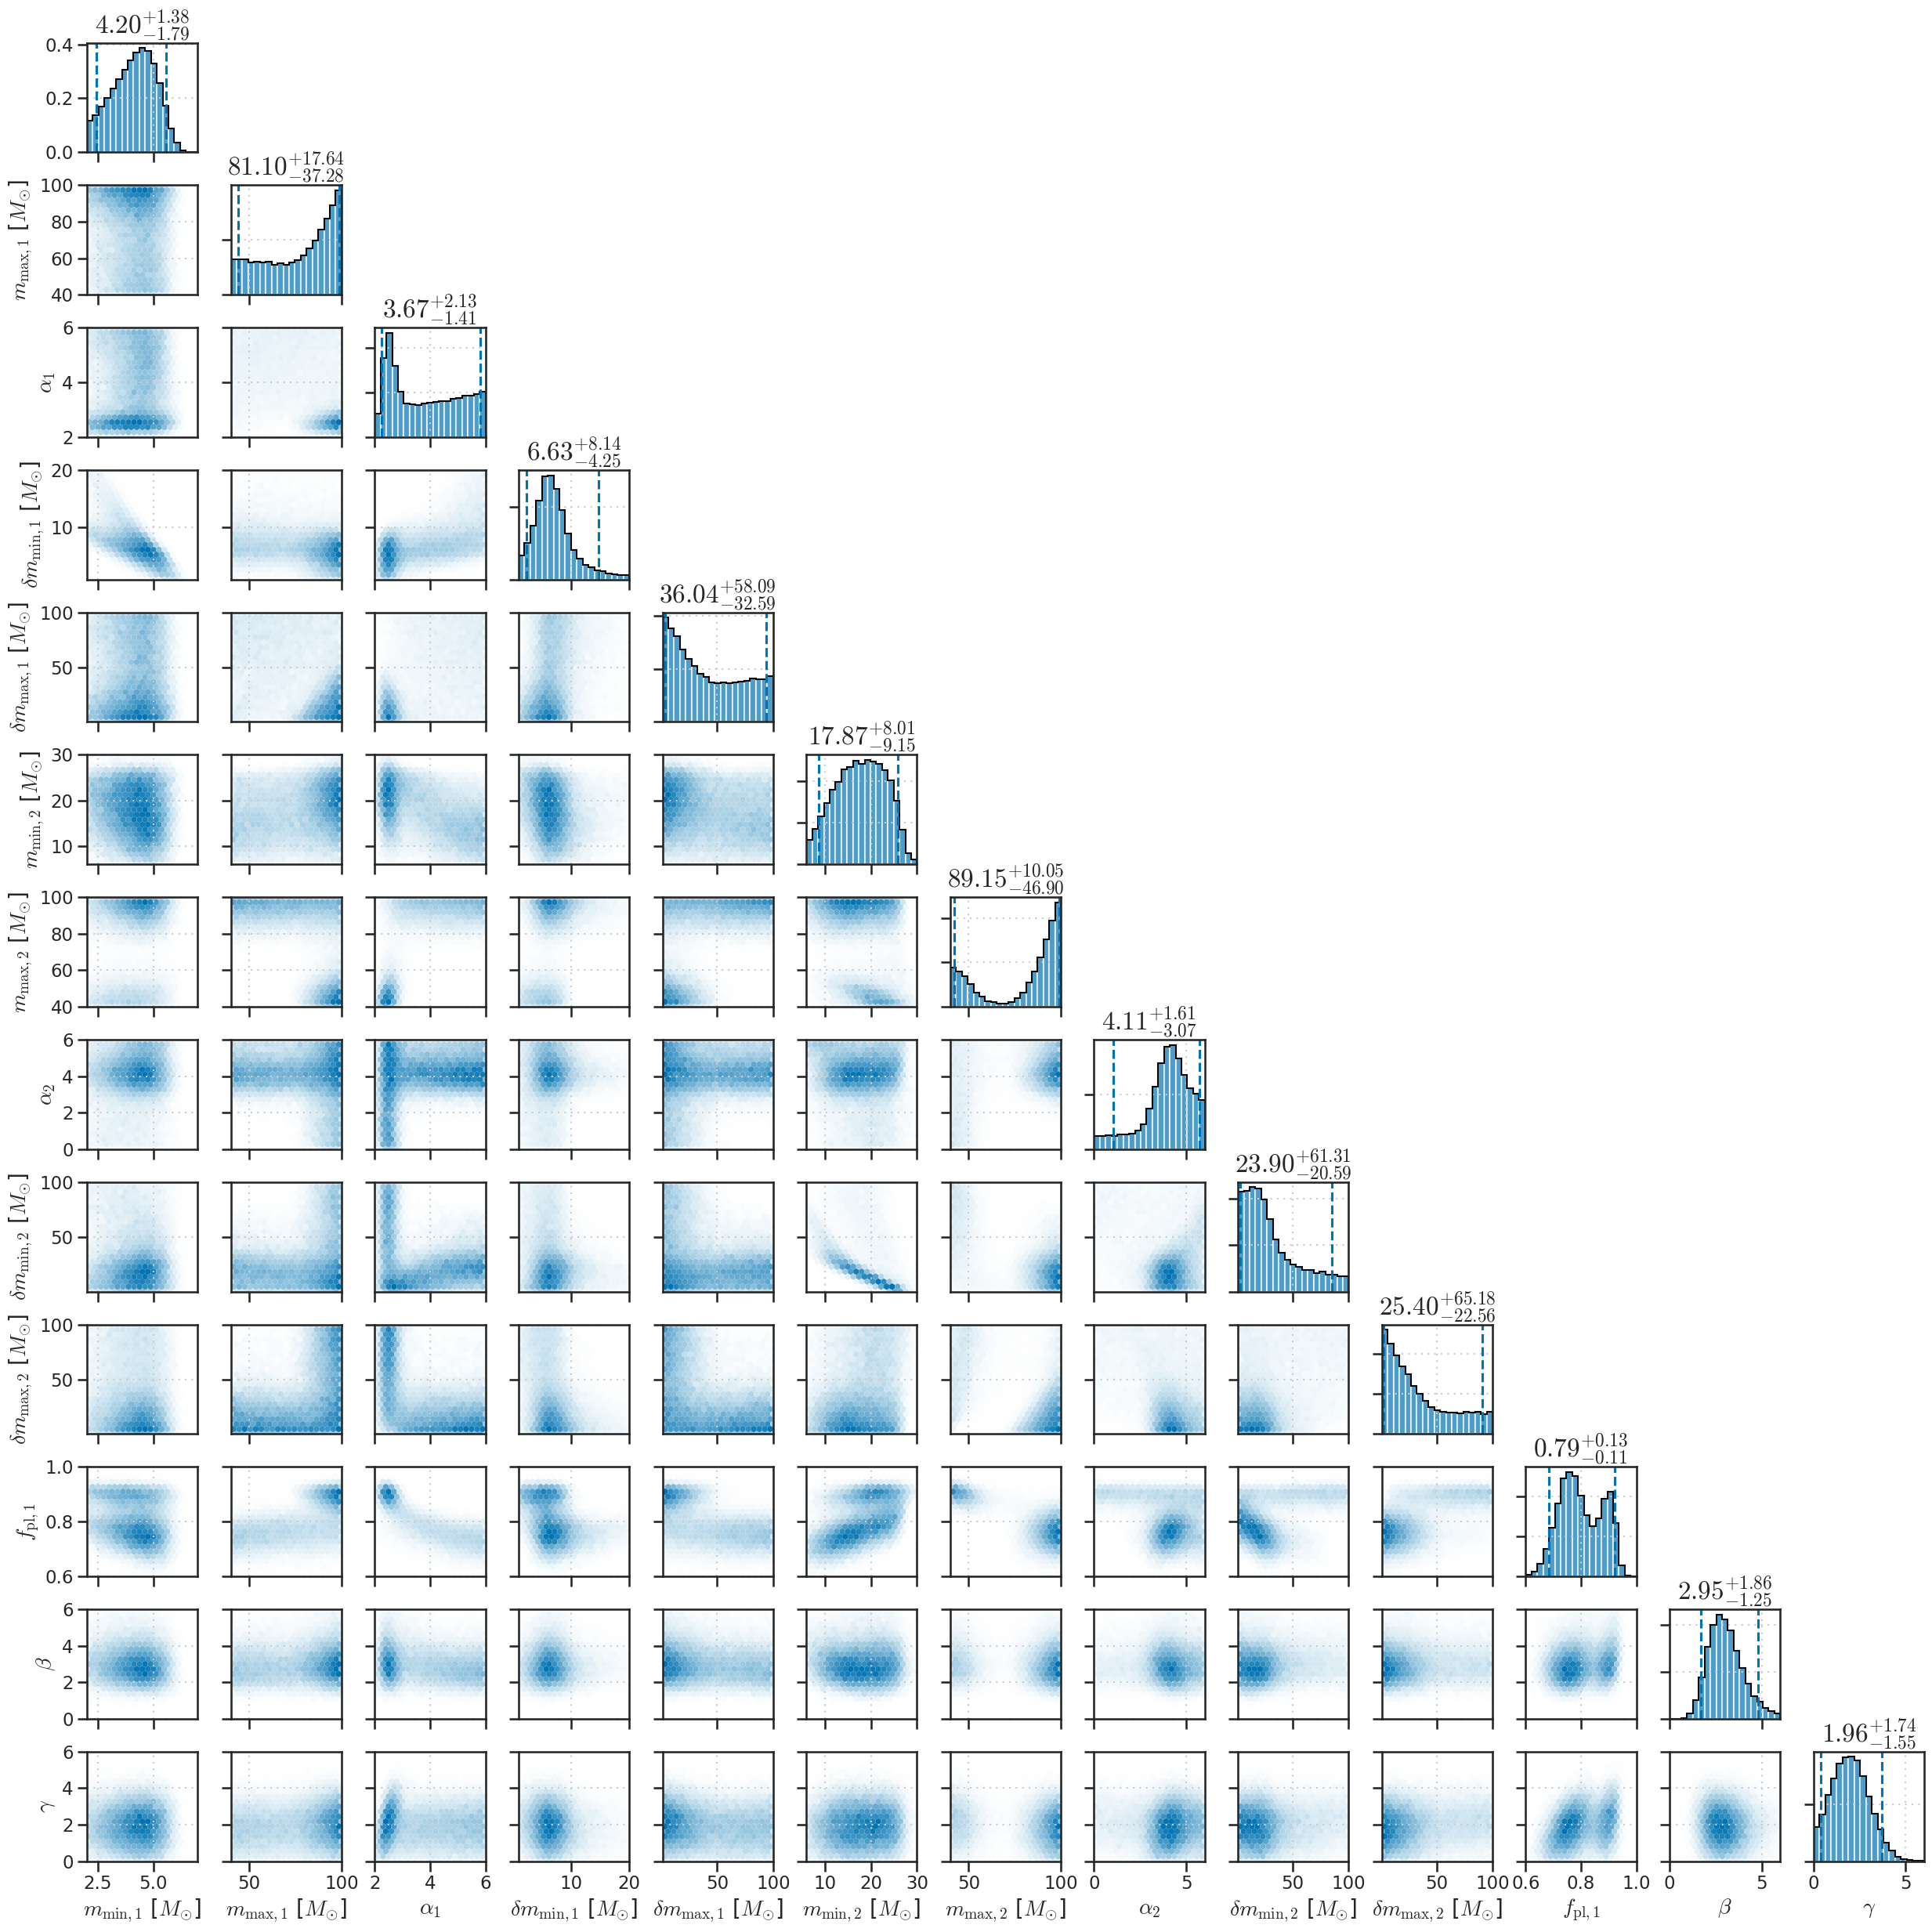

In [9]:
from makeCorner2 import plot_corner

dpostsamples = post_samples_plpl[0]
gamma_1 = dpostsamples[:,0]
mmin_1 = dpostsamples[:,1]
mmax_1 = dpostsamples[:,2]
alpha_1 = dpostsamples[:,3]
dm_mmin_1 = dpostsamples[:,4]
dm_mmax_1 = dpostsamples[:,5]
mmin_2 = dpostsamples[:,6]
mmax_2 = dpostsamples[:,7]
alpha_2 = dpostsamples[:,8]
dm_mmin_2 = dpostsamples[:,9]
dm_mmax_2 = dpostsamples[:,10]
beta = dpostsamples[:,11]
f1 = dpostsamples[:,12]

plpl_labels = [r"$m_{\rm{min},1}$ [$M_{\odot}$]",
                 r"$m_{\rm{max},1}$ [$M_{\odot}$]",
                 r"$\alpha_1$",
                 r"$\delta m_{\rm{min},1}$ [$M_{\odot}$]",
                 r"$\delta m_{\rm{max},1}$ [$M_{\odot}$]",
                 r"$m_{\rm{min},2}$ [$M_{\odot}$]",
                 r"$m_{\rm{max},2}$ [$M_{\odot}$]",
                 r"$\alpha_2$",
                 r"$\delta m_{\rm{min},2}$ [$M_{\odot}$]",
                 r"$\delta m_{\rm{max},2}$ [$M_{\odot}$]",
                 r'$f_{\rm{pl},1}$',
                 r"$\beta$",
                 r"$\gamma$"]

plot_data = {
    'm_min_1':{'data':mmin_1,'plot_bounds':(2,7),'label':plpl_labels[0]},
    'm_max_1':{'data':mmax_1,'plot_bounds':(40,100),'label':plpl_labels[1]},
    'alpha_1':{'data':alpha_1,'plot_bounds':(2,6),'label':plpl_labels[2]},
    'dm_mmin_1':{'data':dm_mmin_1,'plot_bounds':(1,20),'label':plpl_labels[3]},
    'dm_mmax_1':{'data':dm_mmax_1,'plot_bounds':(1,100),'label':plpl_labels[4]},
    'm_min_2':{'data':mmin_2,'plot_bounds':(6,30),'label':plpl_labels[5]},
    'm_max_2':{'data':mmax_2,'plot_bounds':(40,100),'label':plpl_labels[6]},
    'alpha_2':{'data':alpha_2,'plot_bounds':(0,6),'label':plpl_labels[7]},
    'dm_mmin_2':{'data':dm_mmin_2,'plot_bounds':(1,100),'label':plpl_labels[8]},
    'dm_mmax_2':{'data':dm_mmax_2,'plot_bounds':(1,100),'label':plpl_labels[9]},
    'f':{'data':f1,'plot_bounds':(0.6,1),'label':plpl_labels[10]},    
    'beta':{'data':beta,'plot_bounds':(0,6),'label':plpl_labels[11]},
    'gamma':{'data':gamma_1,'plot_bounds':(0,6),'label':plpl_labels[12]}

}

fig = plt.figure(figsize=(25,25))
plot_corner(fig,plot_data,c[0],labelsize=20,title_size=24)

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.savefig('PLPL_corner.pdf',bbox_inches='tight',dpi=200)
plt.show()

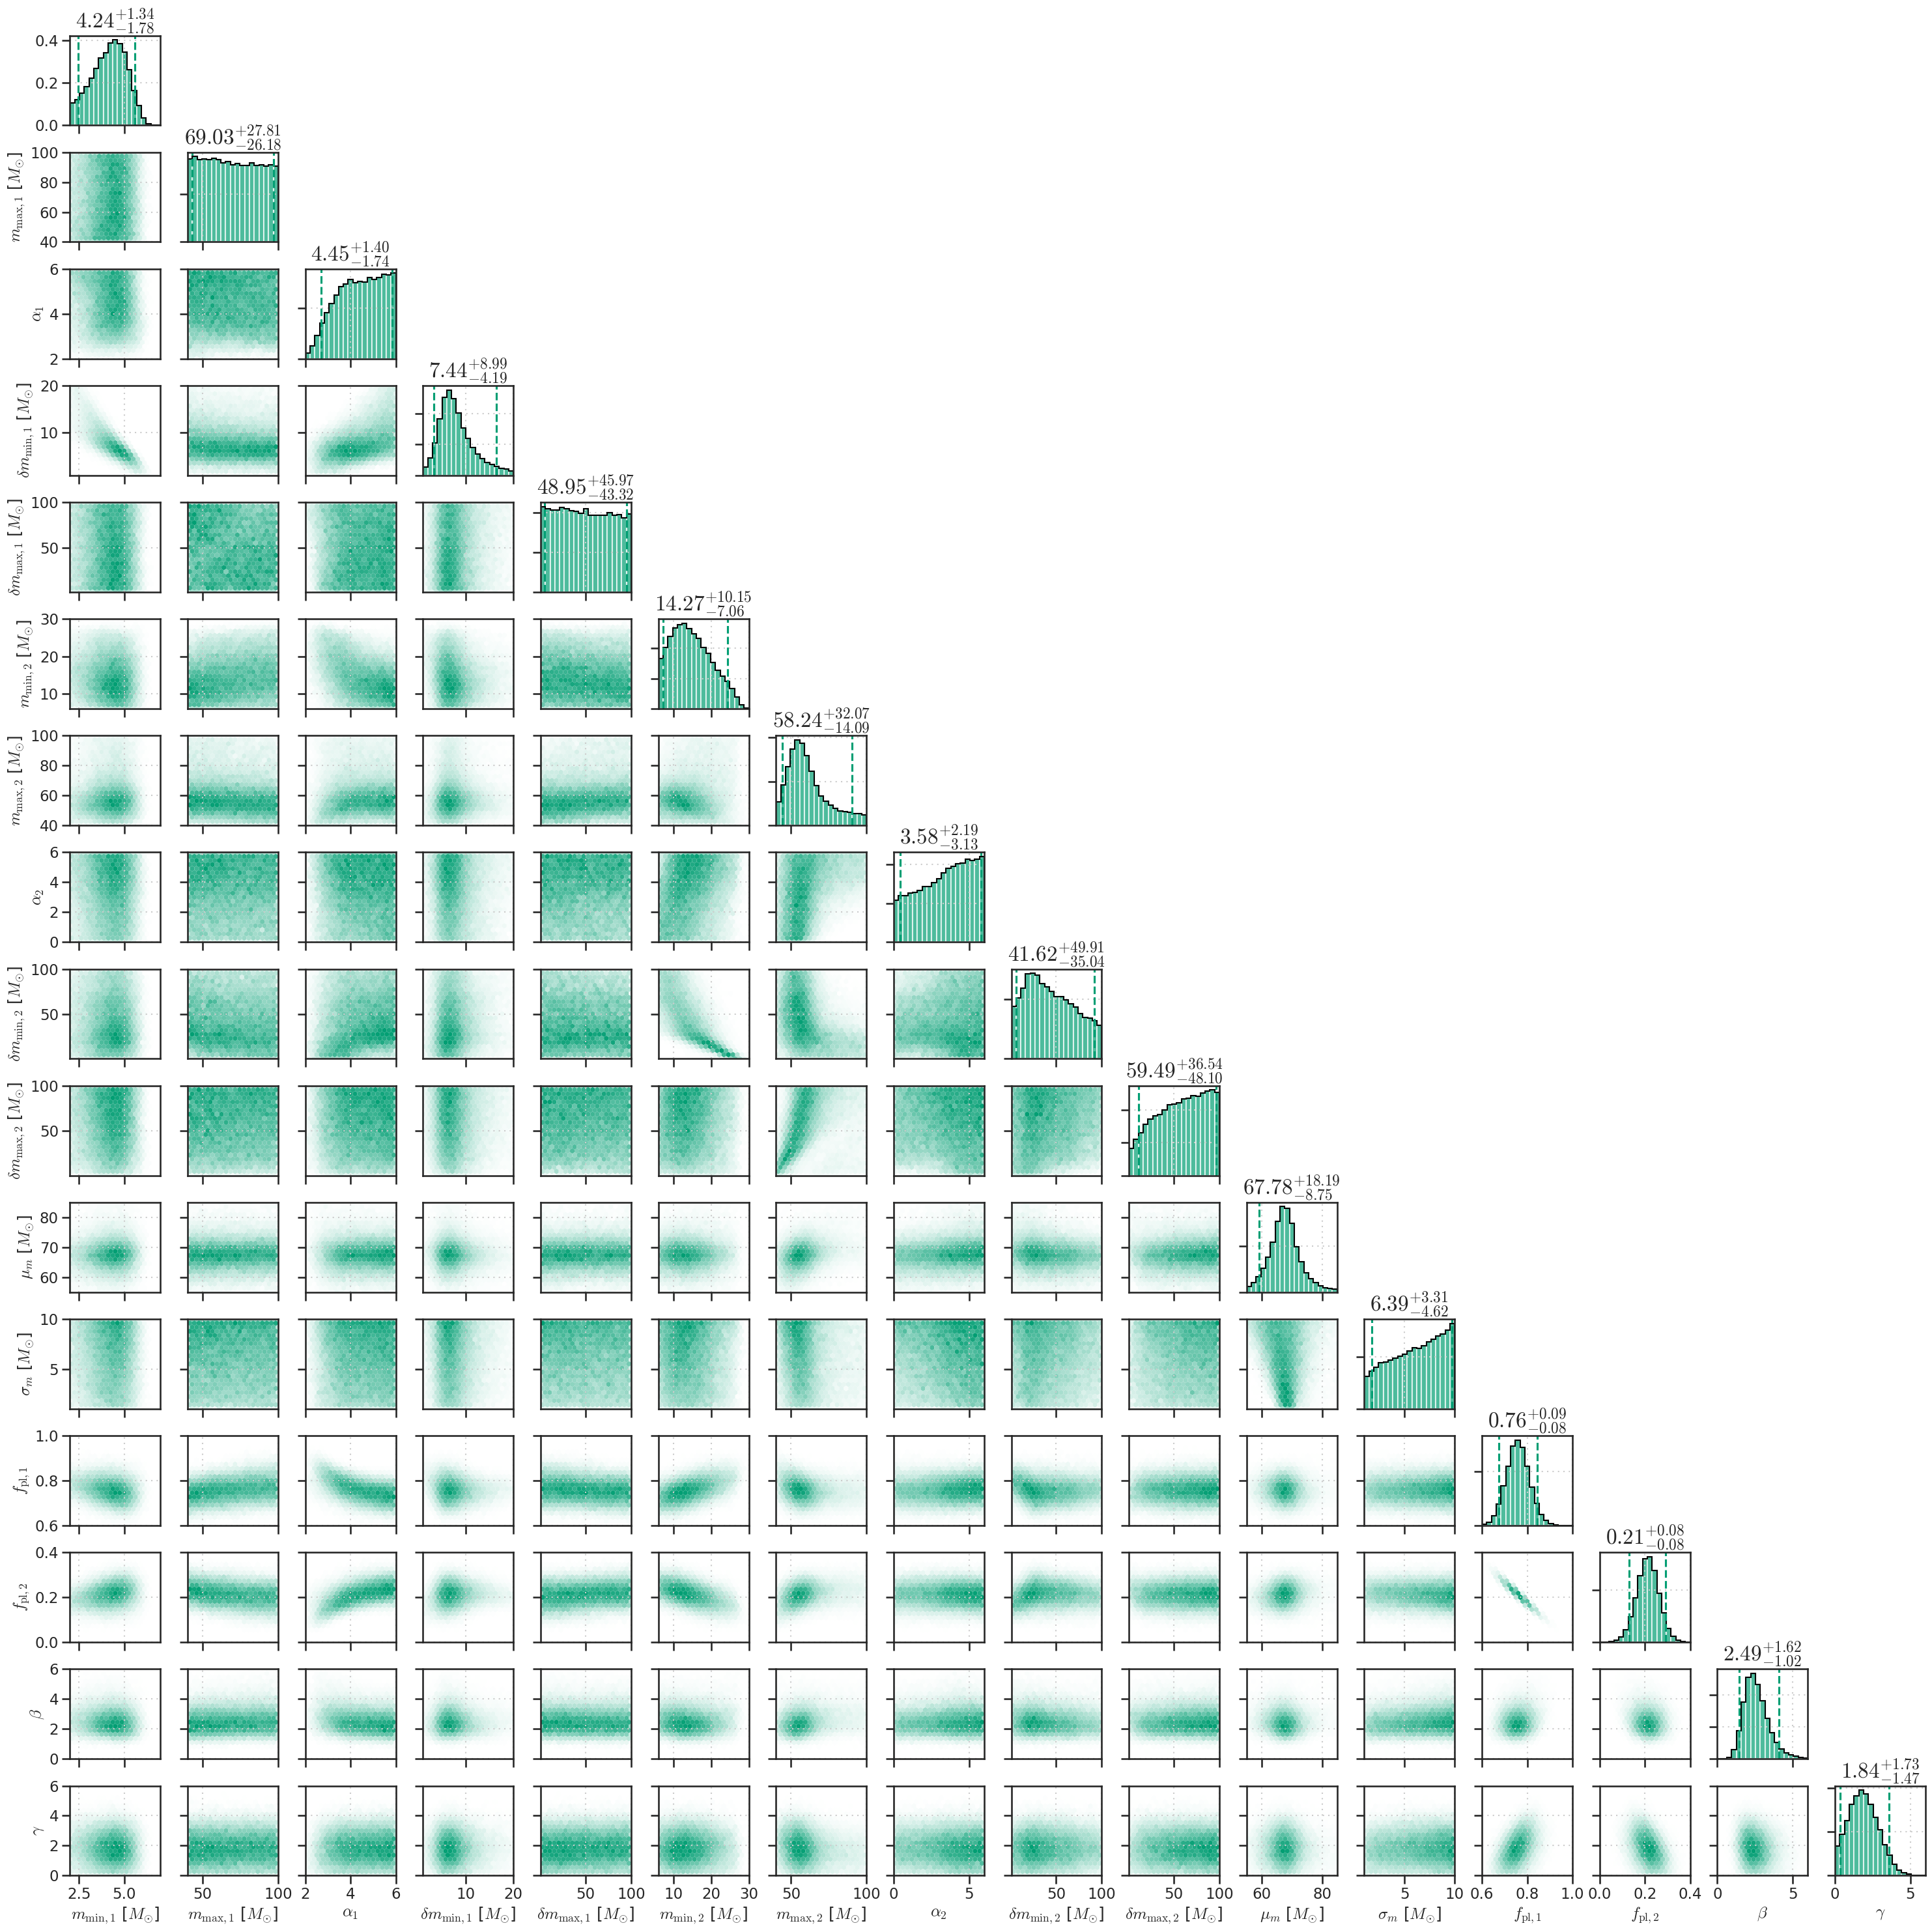

In [10]:
from makeCorner2 import plot_corner

dpostsamples = post_samples_plplbump[0]
gamma_1 = dpostsamples[:,0]
mmin_1 = dpostsamples[:,1]
mmax_1 = dpostsamples[:,2]
alpha_1 = dpostsamples[:,3]
dm_mmin_1 = dpostsamples[:,4]
dm_mmax_1 = dpostsamples[:,5]
mmin_2 = dpostsamples[:,6]
mmax_2 = dpostsamples[:,7]
alpha_2 = dpostsamples[:,8]
dm_mmin_2 = dpostsamples[:,9]
dm_mmax_2 = dpostsamples[:,10]
beta = dpostsamples[:,11]
mu = dpostsamples[:,12]
sigma = dpostsamples[:,13]
f1 = dpostsamples[:,14]
f2 = dpostsamples[:,15]

plplb_labels = [r"$m_{\rm{min},1}$ [$M_{\odot}$]",
                 r"$m_{\rm{max},1}$ [$M_{\odot}$]",
                 r"$\alpha_1$",
                 r"$\delta m_{\rm{min},1}$ [$M_{\odot}$]",
                 r"$\delta m_{\rm{max},1}$ [$M_{\odot}$]",
                 r"$m_{\rm{min},2}$ [$M_{\odot}$]",
                 r"$m_{\rm{max},2}$ [$M_{\odot}$]",
                 r"$\alpha_2$",
                 r"$\delta m_{\rm{min},2}$ [$M_{\odot}$]",
                 r"$\delta m_{\rm{max},2}$ [$M_{\odot}$]",
                 r"$\mu_{m}$ [$M_{\odot}$]",
                 r"$\sigma_{m}$ [$M_{\odot}$]",
                 r'$f_{\rm{pl},1}$',
                 r'$f_{\rm{pl},2}$',
                 r"$\beta$",
                 r"$\gamma$"]

plot_data = {
    'm_min_1':{'data':mmin_1,'plot_bounds':(2,7),'label':plplb_labels[0]},
    'm_max_1':{'data':mmax_1,'plot_bounds':(40,100),'label':plplb_labels[1]},
    'alpha_1':{'data':alpha_1,'plot_bounds':(2,6),'label':plplb_labels[2]},
    'dm_mmin_1':{'data':dm_mmin_1,'plot_bounds':(1,20),'label':plplb_labels[3]},
    'dm_mmax_1':{'data':dm_mmax_1,'plot_bounds':(1,100),'label':plplb_labels[4]},
    'm_min_2':{'data':mmin_2,'plot_bounds':(6,30),'label':plplb_labels[5]},
    'm_max_2':{'data':mmax_2,'plot_bounds':(40,100),'label':plplb_labels[6]},
    'alpha_2':{'data':alpha_2,'plot_bounds':(0,6),'label':plplb_labels[7]},
    'dm_mmin_2':{'data':dm_mmin_2,'plot_bounds':(1,100),'label':plplb_labels[8]},
    'dm_mmax_2':{'data':dm_mmax_2,'plot_bounds':(1,100),'label':plplb_labels[9]},
    'mu':{'data':mu,'plot_bounds':(55,85),'label':plplb_labels[10]},
    'sigma':{'data':sigma,'plot_bounds':(1,10),'label':plplb_labels[11]},
    'f1':{'data':f1,'plot_bounds':(0.6,1),'label':plplb_labels[12]},
    'f2':{'data':f2,'plot_bounds':(0,0.4),'label':plplb_labels[13]},    
    'beta':{'data':beta,'plot_bounds':(0,6),'label':plplb_labels[14]},
    'gamma':{'data':gamma_1,'plot_bounds':(0,6),'label':plplb_labels[15]}

}

fig = plt.figure(figsize=(30,30))
plot_corner(fig,plot_data,c[2],labelsize=18,title_size=24)

plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.savefig('PLPLB_corner.pdf',bbox_inches='tight',dpi=200)
plt.show()

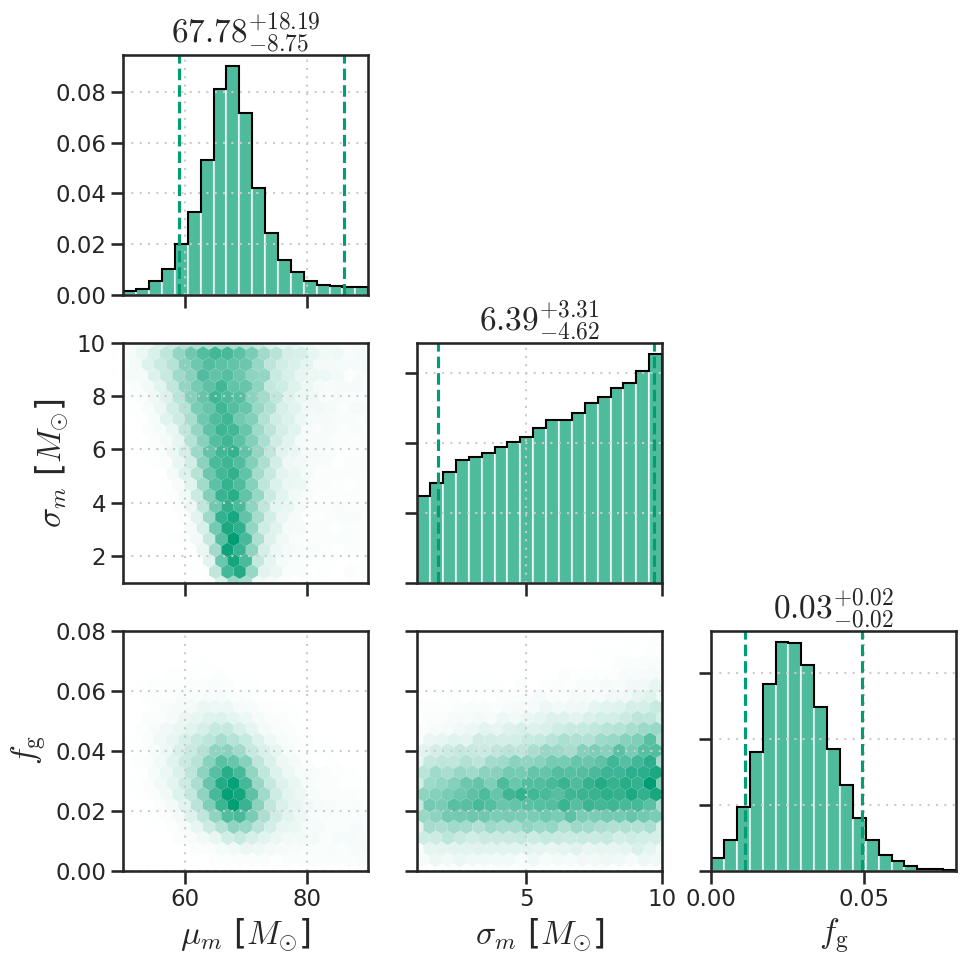

In [11]:
from makeCorner2 import plot_corner

labels_plot_peak = ["$\mu_{m}$ [$M_{\\odot}$]", "$\sigma_{m}$ [$M_{\\odot}$]",  r'$f_{\rm{g}}$']
mu_m = post_samples_plplbump[0][:,12]
sigma_m = post_samples_plplbump[0][:,13]
fpl1 = post_samples_plplbump[0][:,-2]
fpl2 = post_samples_plplbump[0][:,-1]
fpeak = 1 - fpl1 - fpl2


plot_data = {
    'mu':{'data':mu_m,'plot_bounds':(50,90),'label':labels_plot_peak[0]},
    'sigma':{'data':sigma_m,'plot_bounds':(1,10),'label':labels_plot_peak[1]},
    'fpeak':{'data':fpeak,'plot_bounds':(0,0.08),'label':labels_plot_peak[2]}
}

fig = plt.figure(figsize=(10,10))
plot_corner(fig,plot_data,c[2],labelsize=24,title_size=24)

plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.savefig('peak_corner.pdf',bbox_inches='tight',dpi=200)
plt.show()